In [275]:
# Rate prediction based on product description

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
import joblib

## Having a look to the raw data

In [276]:
init_data = pd.read_csv("../data/ratings.csv")
print("Length of dataframe before duplicates are removed:", len(init_data))
init_data.head()

Length of dataframe before duplicates are removed: 10000


,TEXT,RATING
0,The shirt was more of a smock. I expected a so...,1
1,The shirt was more of a smock. I expected a so...,1
2,The shirt was more of a smock. I expected a so...,1
3,Just received my order today. When I opened th...,1
4,"First of all, the button hole on this belt nev...",1


### Drop Duplicates and NaNs (nulls)

In [277]:
dp = init_data.drop_duplicates(subset=['TEXT','RATING'])
print("dataframe length after duplicates are removed:", len(dp))

dp.dropna(subset=['TEXT', 'RATING'])
print("dataframe length after NaNs are removed:", len(dp))
dp['RATING'].value_counts()

dataframe length after duplicates are removed: 3467
dataframe length after NaNs are removed: 3467


4    877
2    681
1    656
3    633
5    620
Name: RATING, dtype: int64

In [278]:
# Upsampling minority classes
df_majority = dp[dp.RATING==4]
df_minority = dp[dp.RATING!=4]
from sklearn.utils import resample
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=3400,    # to match majority class
                                 random_state=123) # reproducible results
df_minority_upsampled['RATING'].value_counts()
df_upsampled = pd.concat([df_minority_upsampled, df_majority])
df_upsampled.RATING.value_counts()
dp = df_upsampled

Viewing the number of products we have for every rating score?
That's basically the distribution of our data model

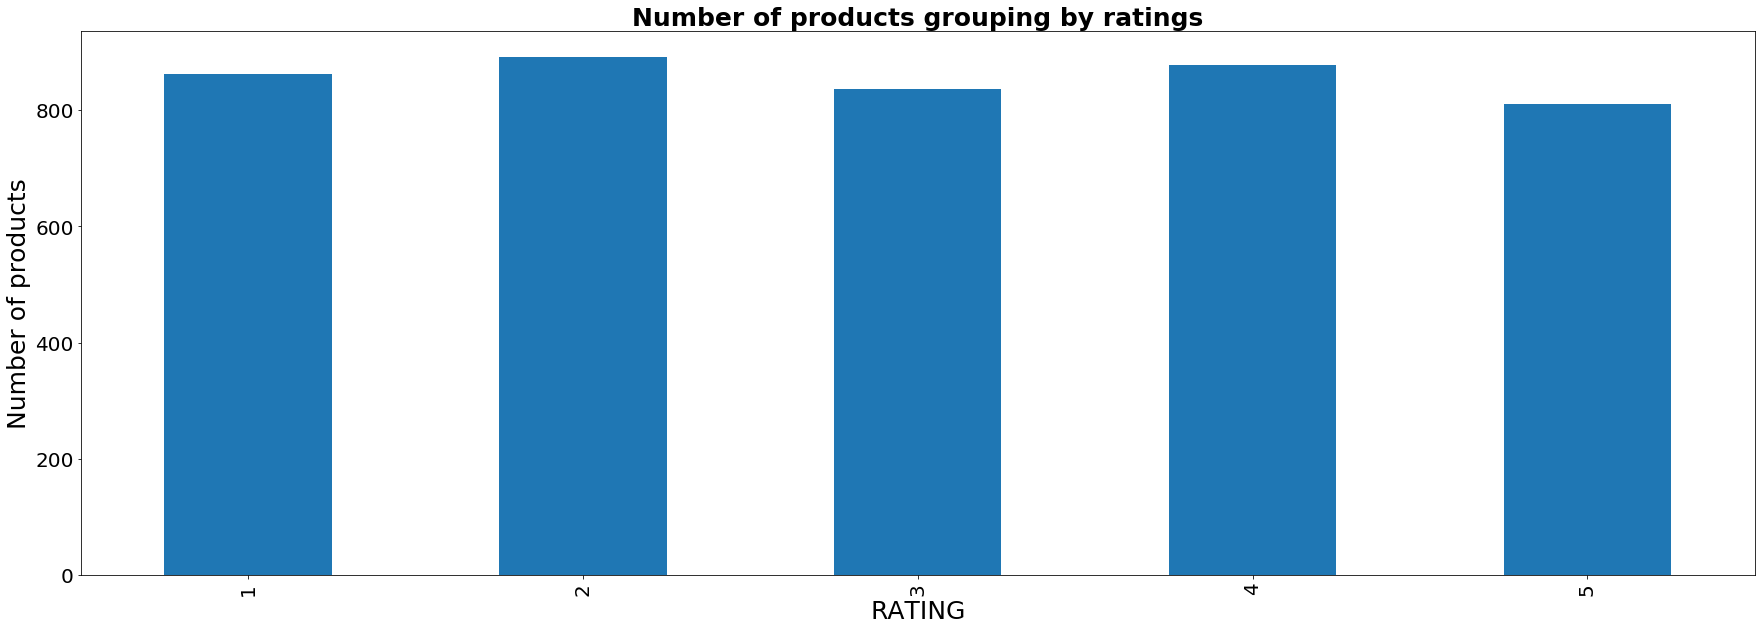

In [279]:
fig, ax = plt.subplots(figsize=(30,10))
plt.xticks(fontsize=20) # X Ticks
plt.yticks(fontsize=20) # Y Ticks
ax.set_title('Number of products grouping by ratings', fontweight="bold", size=25) # Title
ax.set_ylabel('Number of products', fontsize = 25) # Y label
ax.set_xlabel('Rating', fontsize = 25) # X label
dp.groupby(['RATING']).count()['TEXT'].plot(ax=ax, kind='bar')


In [280]:
from collections import Counter
vectorizer = CountVectorizer(stop_words='english',)
for rating in range(1,6):
    bag_of_words = vectorizer.fit_transform(dp[dp.RATING==rating]['TEXT'])
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    print(f'Top 5 frequent words for rating {rating}:')
    print(words_freq[:5])

Top 5 frequent words for rating 1:
[('bra', 478), ('size', 254), ('like', 203), ('fit', 199), ('small', 162)]
Top 5 frequent words for rating 2:
[('bra', 370), ('size', 302), ('fit', 272), ('like', 257), ('bought', 167)]
Top 5 frequent words for rating 3:
[('bra', 533), ('size', 270), ('like', 239), ('fit', 225), ('comfortable', 195)]
Top 5 frequent words for rating 4:
[('bra', 404), ('size', 275), ('like', 241), ('comfortable', 237), ('fit', 216)]
Top 5 frequent words for rating 5:
[('love', 292), ('great', 236), ('bra', 222), ('size', 206), ('wear', 205)]


## Generate training and test datasets
CountVectorizer with english dict as stopwords for description text classification and split the training and test datasets.

90% of dataset for training and 10% for testing.

In [281]:
X = dp['TEXT']
y = dp['RATING']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
#X_train = vectorizer.fit_transform(X_train)
#X_test = vectorizer.transform(X_test)

In [282]:
# Build a pipeline to  transform the data and train the model
ppl = Pipeline([
              ('vec', CountVectorizer(ngram_range=(1, 4), analyzer='char')),
              ('clf',   RandomForestClassifier())
      ])
      
# Classifier training
ppl.fit(X_train, y_train)

# Classifier testing
y_pred = ppl.predict(X_test)
print('f1 prediction score %s' % f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred)))
#print('cross validations score: %s' % np.mean(cross_val_score(model, X_train, y_train, cv=10)))

# Save the pipeline (vectorizer and classifier)
joblib.dump(ppl, '../data/ppl.pkl', compress=9)

f1 prediction score 0.8363924761210437


['../data/ppl.pkl']

In [284]:
#import joblib
#ppl = joblib.load('../data/ppl.pkl')
#ppl.predict(['I dont like it, unconfortable bad and small'])
#print('f1 prediction score %s' % f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred)))


In [285]:
# Load the saved model and show some test predictions from X_test
import joblib
import random
ppl = joblib.load('../data/ppl.pkl')
#ppl.predict(['I dont like it, unconfortable bad and small'])
y_pred = ppl.predict(X_test)
for i in range(5):
    i = random.randint(0,len(X_test))
    print(f'Text: "{X_test[X_test.keys()[i]]}"\nreal rating: {y_test[y_test.keys()[i]]}\nprediction: {y_pred[i]}\n\n')

Text: "I'm glad i read the reviews first before ordering, because they do run very small. I ordered two sizes up, and they fit fine. They feel comfortable, but they are only good for sleeping in and nothing more."
real rating: 3
prediction: 3


Text: "Very cute, I got a lot of comments on this skirt. I paired it with Target's 3/4 boat-neck plain black top, and everyone thought it was a dress!"
real rating: 5
prediction: 5


Text: "This is a cute green cardigan. I ordered my normal size online and think it runs a tiny bit small and the arms are pretty tight. Also, the knit doesn't have much stretch to it at all so the arms didn't loosen up much at all during the day like you might expect. I should point out that the black pattern you see on the sweater is actually part of the sweater. For some reason I thought it the knit on the sweater was loose and the black you could see was the shirt the model has on underneath. I still like it though."
real rating: 4
prediction: 4


Text: "Ive been